The goal of this notebook is to test whether d-QTLs are e-QTLs

In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Load in all of the data

In [2]:
#First, load in the topsnp matrix
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
top.snp = read.table("top.snp.fdr.txt", sep = "\t", header = T)
head(top.snp)

,gene,snp,fdr
,<chr>,<chr>,<dbl>
1,TUT1,chr11:62578659:C:T,7.962065e-39
2,ECD,chr10:73094386:A:G,7.230154e-36
3,MRTO4,chr1:19252818:GT:G,1.689572e-34
4,RPS5,chr19:58365001:A:G,4.034371e-31
5,RESP18,chr2:219320135:G:A,3.977248e-28
6,SRP14,chr15:40035497:C:G,1.121033e-27


In [3]:
#Load in the SNP genotype matrix and format it
#First, load in the sample names
setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
sample.names = read.table("sample.names", sep = "\t") %>%
pull(1) %>%
c("snp", .)

#load in the filtered SNPS
setwd("/home/jupyter/Ancestry/analysis/new_locus_topsnp_ancestry_association")
filtered.snps = read.table("extracted.snps", sep = "\t") 

#Now assemble the big matrix
assembled.matrix = filtered.snps %>%
select(-1, -2, -3, -4, -5, -6, -7, -8, -9) %>%
apply(2, function(x){gsub(":..*", "", x)}) %>%
apply(2, function(x){gsub("0\\|0", "0", x)}) %>%
apply(2, function(x){gsub("0\\|1", "1", x)}) %>%
apply(2, function(x){gsub("1\\|0", "1", x)}) %>%
apply(2, function(x){gsub("1\\|1", "2", x)}) %>%
data.frame() %>%
mutate("snp" = filtered.snps$V3, .before = 1) %>%
rename_all(funs( c(sample.names) ))

#Inspect the output
head(assembled.matrix)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


,snp,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,ACH-000971,ACH-000178,ACH-000822,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1:914838:T:A,0,1,0,0,2,2,2,0,2,⋯,2,1,1,0,1,1,1,1,2,1
2,chr1:2166675:GC:G,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,1
3,chr1:2763943:AG:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,chr1:3790892:G:GC,2,2,2,2,0,2,0,2,1,⋯,2,0,0,2,2,2,1,2,2,1
5,chr1:7630154:T:C,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,chr1:14141375:C:G,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
#Load in the depmap expression data 
setwd("/home/jupyter/Ancestry/analysis/are_dqtls_eqtls")
depmap.expression = read.table("CCLE_expression.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1))

head(depmap.expression)

,,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,⋯,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-001113,4.990501,0.0000000,7.273702,2.765535,4.480265,0.02856915,1.26903315,3.058316,6.483171,⋯,1.2141248,0.00000000,0.11103131,0.15055968,1.4276062,5.781884,0,0.00000000,0.7990873,0.00000000
2,ACH-001289,5.209843,0.5459684,7.070604,2.538538,3.510962,0.00000000,0.17632277,3.836934,4.200850,⋯,1.8359241,0.00000000,0.31034012,0.00000000,0.8073549,4.704319,0,0.00000000,0.4646683,0.07038933
3,ACH-001339,3.779260,0.0000000,7.346425,2.339137,4.254745,0.05658353,1.33913738,6.724241,3.671293,⋯,1.8237494,0.08406426,0.17632277,0.04264434,1.3840498,4.931683,0,0.02856915,0.2630344,0.00000000
4,ACH-001538,5.726831,0.0000000,7.086189,2.543496,3.102658,0.00000000,5.91456452,6.099716,4.475733,⋯,0.8718436,0.13750352,0.26303441,2.48542683,0.7136958,3.858976,0,0.00000000,0.0000000,0.00000000
5,ACH-000242,7.465648,0.0000000,6.435462,2.414136,3.864929,0.83187724,7.19800296,5.452530,7.112492,⋯,2.3248106,0.16349873,0.16349873,0.00000000,1.1176950,4.990501,0,0.00000000,0.0000000,0.00000000
6,ACH-000708,4.914086,0.1763228,6.946848,2.577731,3.853996,0.00000000,0.08406426,4.855491,4.934045,⋯,2.3103401,0.12432814,0.05658353,0.08406426,2.4982509,5.303781,0,0.00000000,0.2630344,0.00000000


In [5]:
#Load in the ancestry-associated genes 
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
ancestry.associated.genes = read.table("ancestry_locus_gene_associations.txt", sep = "\t", header = T) %>%
filter(FDR < 0.05) %>%
pull(gene) %>%
unique()

ancestry.associated.genes

[1] "CAAP1"    "CDKN2B"   "DMRTA1"   "EEF2"     "ELAVL2"   "IFNA10"  
 [7] "IFNA14"   "IFNA16"   "IFNA4"    "IFNA6"    "IFNA8"    "IFNB1"   
[13] "IFNE"     "IFNK"     "IZUMO3"   "MOB3B"    "MTAP"     "RESP18"  
[19] "TEK"      "ZNF236"   "ZNF407"   "ABHD5"    "ADCY3"    "BTG1"    
[25] "C22orf31" "C2orf80"  "CBFA2T2"  "CCDC102B" "CCDC74B"  "CCL3"    
[31] "CEP19"    "CHGB"     "CLPSL1"   "CLSPN"    "COX6B1"   "CSTA"    
[37] "DCN"      "DDX47"    "DND1"     "ECD"      "FAM25A"   "FCGR3A"  
[43] "FRG2C"    "GLYCTK"   "GRB2"     "HINT3"    "INCENP"   "ITGA3"   
[49] "KIAA2013" "KLF5"     "MATR3"    "MDN1"     "MRTO4"    "MYH11"   
[55] "NIT2"     "NOP56"    "NPEPPS"   "NPHS1"    "PDXDC1"   "PEX11A"  
[61] "PTPN11"   "QRICH2"   "RAB21"    "RETNLB"   "RHD"      "RIMS2"   
[67] "RPS5"     "RTP5"     "SART1"    "SLC10A5"  "SLC52A2"  "SLC5A11" 
[73] "SNAP23"   "SPATA6L"  "SRP14"    "STX4"     "STXBP3"   "TPSD1"   
[79] "TRMT61B"  "TTC4"     "TUT1"     "TXNRD1"   "UGT2B17"  "WSB2"    
[85] "ZNF675"   "ZYG11A"   "ACAN"     "DEFB108B" "EGR4"     "NKAIN4"  
[91] "NOMO2"    "PIGN"     "RPL3"     "RPP30"    "RRP7A"    "TP63"    
[97] "VRK1"     "YTHDF2"

In [6]:
#Filter the expression data so that it only includes the ancestry-associated genes
filtered.depmap.expression = depmap.expression %>%
rename("sample" = 1) %>%
select(sample, all_of(ancestry.associated.genes))

dim(filtered.depmap.expression)
head(filtered.depmap.expression)

[1] 1393   99

,sample,CAAP1,CDKN2B,DMRTA1,EEF2,ELAVL2,IFNA10,IFNA14,IFNA16,IFNA4,⋯,EGR4,NKAIN4,NOMO2,PIGN,RPL3,RPP30,RRP7A,TP63,VRK1,YTHDF2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-001113,3.894333,0.00000000,0.00000000,9.068859,0.25096157,0.00000000,0.00000000,0,0,⋯,0.07038933,0.00000000,6.296457,4.221877,10.58346,5.526695,4.568640,8.25323294,5.380245,5.430285
2,ACH-001289,4.602884,3.22187708,0.08406426,10.348064,1.06350294,0.00000000,0.05658353,0,0,⋯,0.01435529,0.00000000,6.300124,4.262283,11.17368,6.134837,4.642702,0.18903382,5.358607,6.018590
3,ACH-001339,3.663345,4.16108148,0.78240856,8.819349,0.07038933,0.02856915,0.05658353,0,0,⋯,0.00000000,0.85598970,5.771357,3.891419,10.29967,5.838952,5.144862,0.31034012,5.189429,6.014355
4,ACH-001538,4.331992,4.39711841,1.13093087,9.836492,0.32192809,0.00000000,0.00000000,0,0,⋯,0.54596837,0.12432814,4.635174,3.541019,11.12838,6.060264,3.712596,7.14435234,5.421897,5.493135
5,ACH-000242,3.776104,0.02856915,0.01435529,10.044257,0.02856915,0.00000000,0.00000000,0,0,⋯,0.05658353,0.00000000,6.056584,3.747387,11.62543,5.247928,5.632559,6.34234140,6.007196,5.877990
6,ACH-000708,4.422233,1.80322704,0.11103131,10.001127,0.89530262,0.00000000,0.00000000,0,0,⋯,0.16349873,0.01435529,6.897240,2.857981,10.74735,5.635174,4.589763,0.04264434,5.249066,5.287989


# Now calculate if any of the SNPs are eQTLs

In [7]:
pval.vector = NULL
differential.expression.vector = NULL

for(i in 1:nrow(top.snp)){
    
    #Get the important information from top.snp
    gene.of.interest = top.snp[i,1] #Get the gene for this iteration of the loop
    snp.of.interest = top.snp[i,2] #Get the snp location for this iteration of the loop
    
    #extract the expression values for that gene
    filtered.goi.expression = filtered.depmap.expression %>%
    select(sample, all_of(gene.of.interest)) %>%
    rename("goi" = 2)
    
    #get a vector of cell lines with (and without) the SNP of interest
    lines.with.snp = assembled.matrix %>% filter(snp %in% all_of(snp.of.interest)) %>% 
    t() %>% 
    data.frame() %>%
    rename("genotype" = 1) %>%
    filter(genotype %in% c(0, 1, 2)) %>%
    mutate(genotype = as.numeric(genotype)) %>%
    filter(genotype >= 1) %>%
    row.names()
    
    lines.without.snp = assembled.matrix %>% filter(snp %in% all_of(snp.of.interest)) %>% 
    t() %>% 
    data.frame() %>%
    rename("genotype" = 1) %>%
    filter(genotype %in% c(0, 1, 2)) %>%
    mutate(genotype = as.numeric(genotype)) %>%
    filter(genotype == 0) %>%
    row.names()
    
    #Split the expression data by snp status
    expression.with.snp = filtered.goi.expression %>% filter(sample %in% all_of(lines.with.snp)) %>% pull(goi)
    expression.without.snp = filtered.goi.expression %>% filter(sample %in% all_of(lines.without.snp)) %>% pull(goi)
    
    #calculate the differential expression
    differential.expression = median(expression.with.snp) - median(expression.without.snp)
    
    #calculate a p-value
    if(length(expression.with.snp) >= 3 && length(expression.without.snp >= 3)){
        pval = t.test(expression.with.snp, expression.without.snp)$p.value  
    } else {
        pval = 1
    }
    
    #add all of the stuff outside of the vector
    pval.vector = c(pval.vector, pval)
    differential.expression.vector = c(differential.expression.vector, differential.expression)
}

In [8]:
#Assemble a data frame with all of the output

eqtl.df = top.snp %>%
mutate("eqtl.pval" = pval.vector) %>%
mutate("eqtl.differential" = differential.expression.vector) %>%
arrange(eqtl.pval) %>%
mutate(eqtl.fdr = p.adjust(eqtl.pval, method = "BH", n = length(eqtl.pval))) %>%
mutate(abs.differential = abs(eqtl.differential))

head(eqtl.df)


#calculate the median differential for all genes with fdr < 0.05
eqtl.df %>% 
filter(eqtl.fdr < 0.05) %>%
pull(eqtl.differential) %>%
abs() %>%
median()

#calculate the number of SNPs that have a fdr < 0.05
eqtl.df %>%
filter(eqtl.fdr < 0.05) %>%
nrow()

,gene,snp,fdr,eqtl.pval,eqtl.differential,eqtl.fdr,abs.differential
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CDKN2B,chr9:21986219:C:T,1.616279e-08,1.091612e-53,-2.54985870,1.069780e-51,2.54985870
2,IFNE,chr9:21340131:A:G,5.865190e-06,2.656700e-14,-0.24867911,1.301783e-12,0.24867911
3,RHD,chr1:25235176:G:A,2.881802e-24,2.784879e-10,-0.11973924,9.097270e-09,0.11973924
4,TEK,chr9:27336435:T:A,3.492504e-04,1.566423e-09,-0.01421386,3.837737e-08,0.01421386
5,TRMT61B,chr2:28796023:T:C,8.904977e-23,6.025317e-09,-0.18413662,1.180962e-07,0.18413662
6,ACAN,chr1:235898921:T:C,4.264121e-01,1.184990e-07,0.03485449,1.935484e-06,0.03485449


[1] 0.1246873

[1] 20

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


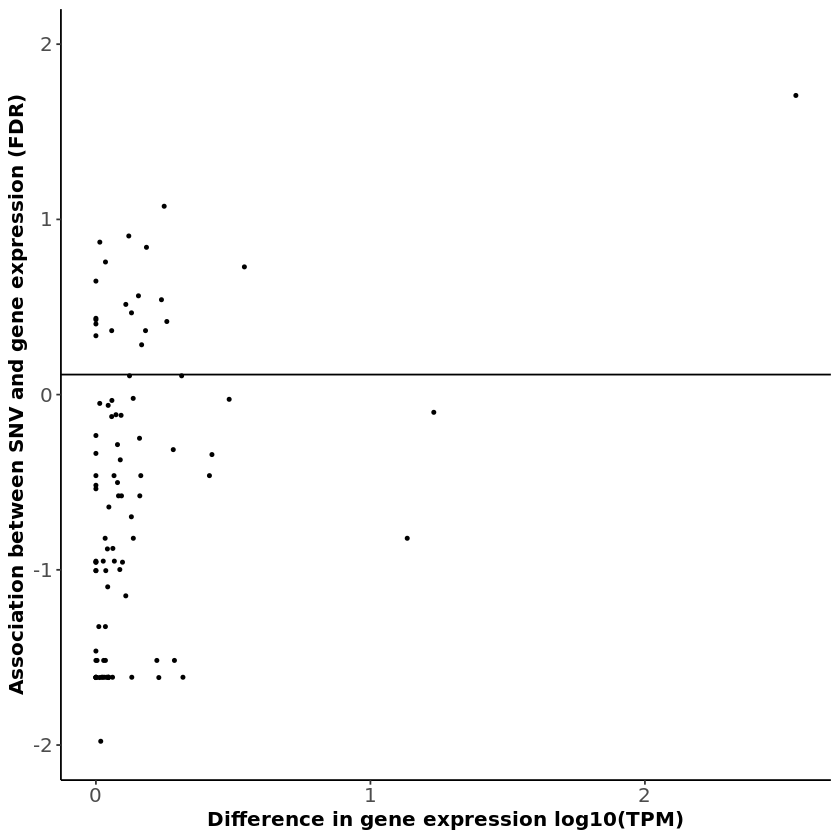

In [19]:
#Plot the plot
eqtl.df %>%
ggplot() +
geom_point(size = 0.75, aes(x = abs.differential, y = log10(-log10(eqtl.fdr)))) +
geom_hline(yintercept = 0.114287) +
theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12, face = "bold"),
axis.title.y = element_text(color = "black", size = 12, face = "bold")
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylim(c(-2, 2)) +

ylab("Association between SNV and gene expression (FDR)") +
xlab("Difference in gene expression log10(TPM)")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/are_dqtls_eqtls')
ggsave("eqtl_volcano.pdf", height = 2.8, width = 1.75)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/are_dqtls_eqtls
gsutil cp eqtl_volcano.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [22]:
#Calculate how many genes don't have eQTLs
eqtl.df %>%
filter(eqtl.fdr > 0.05) %>%
nrow()

dim(eqtl.df)

[1] 78

[1] 98  7

# Calculate the median expression value for all ancestry-associated genes

In [60]:
#Calculate the median expression value for all ancestry-associated genes
median.expression.value = filtered.depmap.expression %>%
select(-sample) %>%
apply(2, median) %>%
data.frame() %>%
rename("expression" = 1) %>%
rownames_to_column() %>%
rename("gene" = 1) %>%
mutate("class" = "ancestry")

head(median.expression.value)

,gene,expression,class
,<chr>,<dbl>,<chr>
1,CAAP1,3.9250500,ancestry
2,CDKN2B,1.6915342,ancestry
3,DMRTA1,0.2265085,ancestry
4,EEF2,9.8482630,ancestry
5,ELAVL2,0.1110313,ancestry
6,IFNA10,0.0000000,ancestry


In [61]:
###Calculate the median expression for all of the common essential genes

#First, load in a list of all of the common essential genes
setwd("/home/jupyter/Ancestry/analysis/are_dqtls_eqtls")
common.essential.genes = read.table("common_essentials.csv", sep = ",", header = T) %>%
mutate(gene = word(gene, 1)) %>%
pull(gene)
length(common.essential.genes)

#Subset these genes from the expression matrix, then calculate the median expression of all genes
intersecting.ce.genes = intersect(common.essential.genes, colnames(depmap.expression))

common.essential.gene.expression = depmap.expression %>%
select(all_of(intersecting.ce.genes)) %>%
apply(2, median) %>% 
data.frame() %>%
rownames_to_column() %>%
rename("gene" = 1, "expression" = 2) %>%
mutate("class" = "common_essential") %>%
sample_n(nrow(median.expression.value))

head(common.essential.gene.expression)


[1] 1247

,gene,expression,class
,<chr>,<dbl>,<chr>
1,VPS52,5.167920,common_essential
2,LRR1,4.718636,common_essential
3,XRN1,3.090853,common_essential
4,TXNL4A,6.206135,common_essential
5,PSMC6,6.527790,common_essential
6,RPN1,7.469967,common_essential


In [62]:
#Bind thme both together
median.expression.value = median.expression.value %>%
rbind(common.essential.gene.expression, .) %>%
mutate(class = factor(class, levels = c("common_essential", "ancestry"))) #Convert the class to a factor so that we can make one appear in front of the other

head(median.expression.value)
tail(median.expression.value)

,gene,expression,class
,<chr>,<dbl>,<fct>
1,VPS52,5.167920,common_essential
2,LRR1,4.718636,common_essential
3,XRN1,3.090853,common_essential
4,TXNL4A,6.206135,common_essential
5,PSMC6,6.527790,common_essential
6,RPN1,7.469967,common_essential


,gene,expression,class
,<chr>,<dbl>,<fct>
191,RPL3,10.7750341,ancestry
192,RPP30,5.4161642,ancestry
193,RRP7A,4.8444861,ancestry
194,TP63,0.1763228,ancestry
195,VRK1,5.0938137,ancestry
196,YTHDF2,5.5257557,ancestry


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



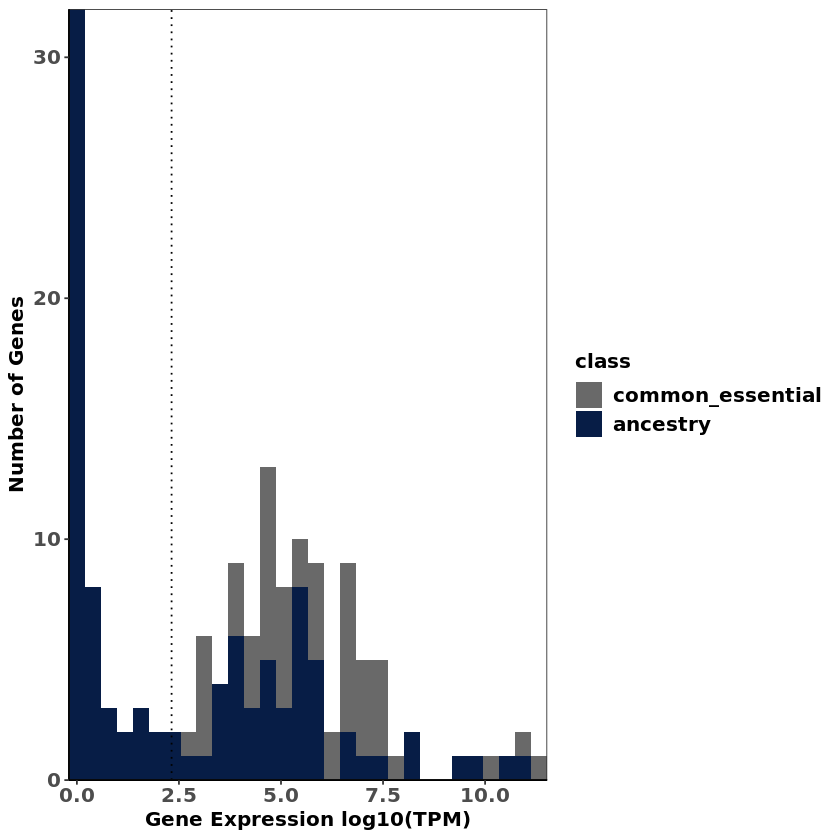

In [85]:
#Now plot a histogram of the median expression values

median.expression.value %>%
ggplot(aes(x = expression)) +
geom_histogram(aes(fill = class), position="identity") +
geom_vline(xintercept = 2.32, linetype = "dotted") + 

scale_color_manual(values=c("dimgrey", "#071d46")) +
scale_fill_manual(values=c("dimgrey", "#071d46")) +

theme_bw() +

theme(
#panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=12),
axis.text.y = element_text(face="bold", size=12)
) +

theme(
axis.title.x = element_text(color = "black", size = 12, face = "bold"),
axis.title.y = element_text(color = "black", size = 12, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
) +

theme(
legend.title = element_text(size = 12, face = "bold"),
legend.text = element_text(size = 12, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0), breaks = c(0, 2.5, 5, 7.5, 10)) +

xlab("Gene Expression log10(TPM)") +
ylab("Number of Genes") 

#Put the exported image into the google bucket
setwd('/home/jupyter/Ancestry/analysis/are_dqtls_eqtls')
ggsave("locus_expression_values.pdf", width = 6, height = 2.3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp /home/jupyter/Ancestry/analysis/are_dqtls_eqtls/locus_expression_values.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [80]:
#Calculate the number of genes whose expression value is less than 2.5
median.expression.value %>%
filter(class %in% "ancestry") %>%
filter(expression < 2.32) %>%
nrow()


#Now do the same for common essentials
median.expression.value %>%
filter(class %in% "common_essential") %>%
filter(expression < 2.32) %>%
nrow()

#How many total genes are there
median.expression.value %>% filter(class %in% "ancestry") %>% nrow()
median.expression.value %>% filter(class %in% "common_essential") %>% nrow()


[1] 50

[1] 2

[1] 98

[1] 98

The CDKN2B finding is interesting. Let's stress test it a bit.

If that SNP (or a SNP in LD) is a true CDKN2B eQTL, then that SNP should probably only be associated with CDKN2B expression, but not expression of other neighboring genes.

In [33]:
#Grab every gene that is on chr9 and test if expression of those genes is also associated with CDKN2B expression
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
refgene = read.table("hg38.refGene.gtf", header = F, sep = "\t") %>%
select(V1, V3, V4, V5, 7, V9) %>%
rename("chr" = V1, "type" = V3, "start" = V4, "end" = V5, "strand" = V7, "gene" = V9) %>%
filter(type %in% "transcript") %>%
mutate("position" = ifelse(strand %in% "+", start, end)) %>%
mutate(gene = gsub(";..*", "", gene)) %>%
mutate(gene = gsub("gene_id ", "", gene)) %>%
select(chr, position, strand, gene) %>%
distinct(gene, .keep_all = TRUE) %>%
filter(chr %in% "chr9") 

head(refgene)
dim(refgene)

genes.on.chr9 = refgene %>% pull(gene) %>%
intersect(names(depmap.expression))

length(genes.on.chr9)


,chr,position,strand,gene
,<chr>,<int>,<chr>,<chr>
1,chr9,127778666,-,SH2D3C
2,chr9,75088514,+,OSTF1
3,chr9,132879046,-,AK8
4,chr9,114930595,-,TNFSF8
5,chr9,27109141,+,TEK
6,chr9,98119222,-,TRIM14


[1] 1091    4

[1] 731

In [19]:
#Get a list of samples with the snp and samples without the snp
samples.with.snp = assembled.matrix %>% filter(snp %in% "chr9:21986219:C:T") %>%
select_if(~max(.) >= 1) %>%
colnames(.) %>%
.[2:length(.)]

samples.without.snp = assembled.matrix %>% filter(snp %in% "chr9:21986219:C:T") %>%
select_if(~min(.) == 0) %>%
colnames(.) %>%
.[2:length(.)]


In [38]:
#Split the expression dataset into these two chunks based upon if the samples have the SNP or not
#Also filter the dataset so that it only includes the genes on chr9
with.snp.chunk = depmap.expression %>% 
rename("sample" = 1) %>%
filter(sample %in% all_of(samples.with.snp)) %>%
select(sample, all_of(genes.on.chr9)) %>%
select(-sample)


without.snp.chunk = depmap.expression %>%
rename("sample" = 1) %>%
filter(sample %in% all_of(samples.without.snp)) %>%
select(sample, all_of(genes.on.chr9)) %>%
select(-sample)


head(with.snp.chunk)
head(without.snp.chunk)

,SH2D3C,OSTF1,AK8,TNFSF8,TEK,TRIM14,SPINK4,KYAT1,ZDHHC21,CDKN2A,⋯,BARHL1,ZER1,QSOX2,PLPP6,BRD3,MPDZ,ERCC6L2,FRRS1L,DPM2,SLC24A2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.78240856,5.227664,0.77399633,0.00000000,0.01435529,4.010780,0.0000000,1.933573,3.586164,0.0000000,⋯,0.04264434,3.513491,3.877744,4.122673,3.494416,4.2311252,4.800123,0.00000000,4.643856,0.20163386
2,0.11103131,5.838448,0.04264434,0.02856915,0.00000000,4.022368,0.5558162,1.713696,2.891419,0.1375035,⋯,0.01435529,3.894333,3.285402,2.648465,2.835924,2.9049657,3.638074,0.04264434,4.556429,0.01435529
3,0.07038933,4.840967,0.66902677,0.01435529,0.00000000,3.993674,0.3673711,2.073820,1.735522,0.3219281,⋯,0.08406426,4.698774,5.151778,2.327687,4.214902,0.0976108,3.791814,0.01435529,6.063719,0.00000000
4,0.05658353,4.577731,0.26303441,0.07038933,0.12432814,2.490570,0.1634987,2.925999,2.232661,6.1424134,⋯,0.05658353,4.985956,4.188243,1.718088,3.693766,2.4032677,3.586164,0.00000000,6.223809,0.00000000
5,0.18903382,3.915521,0.47508488,0.02856915,0.45417589,2.526069,0.0000000,4.275752,2.084064,0.1890338,⋯,0.01435529,4.030336,4.795455,3.361768,3.940167,3.9345165,2.794936,0.00000000,5.953032,0.00000000
6,0.20163386,4.394377,0.81557543,0.01435529,0.86393845,3.612352,0.0000000,3.761285,2.582556,0.2750070,⋯,0.00000000,4.965323,4.268285,3.037382,4.257011,5.2426025,3.911692,2.20476675,5.900625,0.00000000


,SH2D3C,OSTF1,AK8,TNFSF8,TEK,TRIM14,SPINK4,KYAT1,ZDHHC21,CDKN2A,⋯,BARHL1,ZER1,QSOX2,PLPP6,BRD3,MPDZ,ERCC6L2,FRRS1L,DPM2,SLC24A2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.04264434,5.167519,0.35614381,0.08406426,0.01435529,4.858976,7.5161728,3.193772,2.45680615,5.2857721,⋯,0.00000000,3.996389,3.851999,3.165108,3.502076,0.0976108,3.190615,0.01435529,5.667041,0.02856915
2,0.15055968,3.890447,0.05658353,0.02856915,0.04264434,1.298658,0.0000000,1.250962,2.38128337,3.2249664,⋯,0.00000000,2.422233,2.815575,3.200065,1.321928,2.1858665,2.563158,0.00000000,5.082788,0.00000000
3,0.43295941,6.238978,0.48542683,0.05658353,1.12432814,3.916477,0.1243281,2.733354,0.08406426,5.8831320,⋯,0.04264434,3.295723,3.781360,3.061776,3.174726,1.1110313,5.655638,0.00000000,5.046578,0.04264434
4,0.20163386,6.403949,0.25096157,0.00000000,0.00000000,4.042644,0.0000000,1.244887,3.13750352,0.4114262,⋯,0.02856915,3.471187,3.626439,4.144862,3.339137,3.3504972,3.818646,0.00000000,4.635174,0.13750352
5,3.03913839,5.223423,0.01435529,0.21412481,0.00000000,4.891419,2.1570437,2.680324,2.53106949,3.9221978,⋯,0.04264434,2.722466,3.962549,1.056584,2.954196,0.0000000,3.615887,0.00000000,5.442943,0.00000000
6,0.21412481,5.086614,0.12432814,0.08406426,0.01435529,2.985500,6.6201465,2.250962,2.80941444,4.6241009,⋯,0.00000000,3.684819,3.404631,2.843984,3.488001,0.0000000,4.244887,0.00000000,4.475085,0.00000000


In [49]:
#Now loop through both data frames and calculate the median difference and the p-value
chr9.pval.vector = NULL
chr9.differential.vector = NULL
for(i in 1:ncol(with.snp.chunk)){
    
    #extract the two vectors
    snp.expression.vector = with.snp.chunk %>% pull(i)
    without.snp.expression.vector =  without.snp.chunk %>% pull(i)
    
    #calculate the p-value
    pval = t.test(snp.expression.vector, without.snp.expression.vector)$p.value
    
    #calculate the differential
    snp.median = median(snp.expression.vector)
    without.snp.median = median(without.snp.expression.vector)
    median.differential = snp.median - without.snp.median
    
    #Add the data outside of the loop
    chr9.pval.vector[i] = pval
    chr9.differential.vector = median.differential
    
}


#assemble the output dataframe
snp.differential.df = cbind(names(with.snp.chunk), chr9.pval.vector, chr9.differential.vector) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "differential" = 3) %>%
mutate(fdr = p.adjust(pval, method = "BH", n = length(pval))) %>%
arrange(fdr) %>%
inner_join(refgene, by = "gene")

head(snp.differential.df, n = 20)

,gene,pval,differential,fdr,chr,position,strand
,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
1,CDKN2A,1.32099330207663e-89,0,9.656461e-87,chr9,21974827,-
2,CDKN2B,7.89238606248627e-54,0,2.884667e-51,chr9,22009313,-
3,MTAP,1.17012654838137e-29,0,2.851208e-27,chr9,21802636,+
4,KLHL9,2.8321403005231e-15,0,5.175736e-13,chr9,21335404,-
5,ADAMTSL2,8.9317695357349e-11,0,1.305825e-08,chr9,133534704,+
6,ANXA1,9.74927211688655e-10,0,1.187786e-07,chr9,73151865,+
7,CTSL,1.56645062774473e-08,0,1.635822e-06,chr9,87726119,+
8,FOCAD,1.81084176476105e-08,0,1.654657e-06,chr9,20658309,+
9,FAM163B,7.85400193236809e-08,0,6.379195e-06,chr9,133586119,-


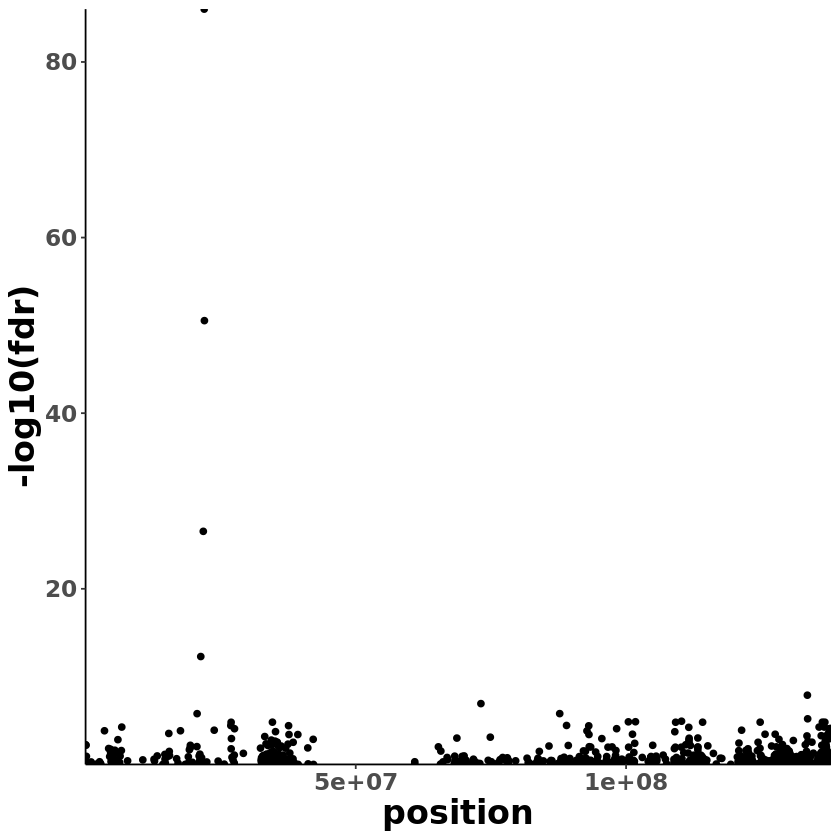

In [65]:
#Plot the p-value as a function of distance from CDKN2A
snp.differential.df %>%
ggplot() +
geom_point(aes(x = position, y = -log10(fdr))) +
theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) 

setwd('/home/jupyter/Ancestry/analysis/are_dqtls_eqtls')
ggsave("pval_by_chr9_location.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp /home/jupyter/Ancestry/analysis/are_dqtls_eqtls/pval_by_chr9_location.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

It's interesting, all of the most significant associations are in very close proximity to that gene. And why is that one SNP associated with expression of multiple genes?

A biological reason is that this SNP is messing with a TAD?

The most likely reason is that this SNP is a CNV artifact. Let's test if this SNP is associated with copy loss at CDKN2A locus.

In [53]:
#Load in the gene-level CN data
setwd("/home/jupyter/Ancestry/analysis/are_dqtls_eqtls")
depmap.cn = read.table("CCLE_gene_cn.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1))

head(depmap.cn)

,,DDX11L1,WASH7P,MIR6859-1,MIR1302-2,FAM138A,OR4F5,WASH9P,MIR6859-2,OR4F29,⋯,TTTY17B,TTTY4B,BPY2B,DAZ3,DAZ4,BPY2C,TTTY4C,CSPG4P1Y,CDY1,TTTY3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-001533,1.0161256,1.0161256,1.0161256,1.0161256,1.0161256,1.0161256,1.0161256,1.0161256,1.0161256,⋯,6.108848e-01,6.108848e-01,6.108848e-01,6.108848e-01,6.108848e-01,6.108848e-01,6.108848e-01,6.108848e-01,6.108848e-01,6.108848e-01
2,ACH-000934,0.8551505,0.8551505,0.8551505,0.8551505,0.8551505,0.8551505,0.8551505,0.8551505,0.8551505,⋯,6.045011e-02,2.473427e-08,2.473427e-08,2.473427e-08,2.473427e-08,2.473427e-08,2.473427e-08,2.473427e-08,2.473427e-08,2.473427e-08
3,ACH-000653,1.0679432,1.0679432,1.0679432,1.0679432,1.0679432,1.0679432,1.0679432,1.0679432,1.0679432,⋯,8.668152e-10,8.668152e-10,8.668152e-10,8.668152e-10,8.668152e-10,8.668152e-10,8.668152e-10,8.668152e-10,8.668152e-10,8.668152e-10
4,ACH-001497,1.0392236,1.0392236,1.0392236,1.0392236,1.0392236,1.0392236,1.0392236,1.0392236,1.0392236,⋯,7.805491e-10,7.805491e-10,7.805491e-10,7.805491e-10,7.805491e-10,7.805491e-10,7.805491e-10,7.805491e-10,7.805491e-10,7.805491e-10
5,ACH-000888,0.7012708,0.7012708,0.7012708,0.7012708,0.7012708,0.7012708,0.7012708,0.7012708,0.7012708,⋯,4.548009e-09,4.548009e-09,4.548009e-09,4.548009e-09,4.548009e-09,4.548009e-09,4.548009e-09,4.548009e-09,4.548009e-09,4.548009e-09
6,ACH-000433,0.9817134,0.9817134,0.9817134,0.9817134,0.9817134,0.9817134,0.9817134,0.9817134,0.9817134,⋯,5.648721e-09,5.648721e-09,5.648721e-09,5.648721e-09,5.648721e-09,5.648721e-09,5.648721e-09,5.648721e-09,5.648721e-09,5.648721e-09


In [59]:
#Extract the CN information for just CDKN2B
cdkn2b.cn = depmap.cn %>%
rename("sample" = 1) %>%
select(sample, CDKN2B)

head(cdkn2b.cn)

#assemble a data frame that has the cell line name and the SNP call for our favorite SNP
cdkn2b.snp = assembled.matrix %>% filter(snp %in% "chr9:21986219:C:T") %>%
select(-snp) %>%
t() %>%
data.frame() %>%
rename("snp.call" = 1) %>%
mutate(sample = row.names(.), .before = snp.call)

head(cdkn2b.snp)

#merge them both together
merged.cn.snp = inner_join(cdkn2b.cn, cdkn2b.snp, by = "sample")
head(merged.cn.snp)

,sample,CDKN2B
,<chr>,<dbl>
1,ACH-001533,9.619635e-01
2,ACH-000934,4.137646e-01
3,ACH-000653,8.212975e-01
4,ACH-001497,7.813944e-01
5,ACH-000888,9.861957e-01
6,ACH-000433,1.391660e-09


,sample,snp.call
,<chr>,<chr>
ACH-000657,ACH-000657,0
ACH-000617,ACH-000617,0
ACH-000685,ACH-000685,0
ACH-000632,ACH-000632,0
ACH-000171,ACH-000171,1
ACH-000863,ACH-000863,1


,sample,CDKN2B,snp.call
,<chr>,<dbl>,<chr>
1,ACH-000934,4.137646e-01,0
2,ACH-000888,9.861957e-01,1
3,ACH-000433,1.391660e-09,1
4,ACH-000717,1.841236e-09,1
5,ACH-000633,9.147949e-01,0
6,ACH-000568,8.341819e-01,0


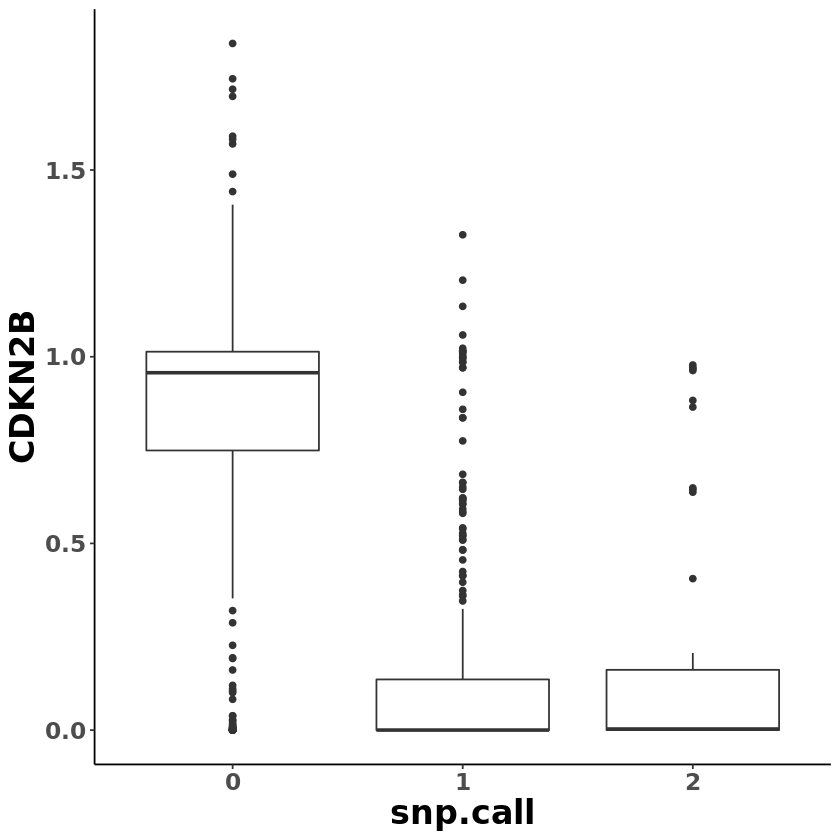

In [64]:
#Now plot the copy number as a function of the SNP call
merged.cn.snp %>%
ggplot() +
geom_boxplot(aes(x = snp.call, y = CDKN2B)) +
theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) 

setwd('/home/jupyter/Ancestry/analysis/are_dqtls_eqtls')
ggsave("cdkn2b_cn_by_snp_status.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp /home/jupyter/Ancestry/analysis/are_dqtls_eqtls/cdkn2b_cn_by_snp_status.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Which gene is associated with multiple SNPs?

In [3]:
head(top.snp)

,gene,snp,fdr
,<chr>,<chr>,<dbl>
1,TUT1,chr11:62578659:C:T,7.962065e-39
2,ECD,chr10:73094386:A:G,7.230154e-36
3,MRTO4,chr1:19252818:GT:G,1.689572e-34
4,RPS5,chr19:58365001:A:G,4.034371e-31
5,RESP18,chr2:219320135:G:A,3.977248e-28
6,SRP14,chr15:40035497:C:G,1.121033e-27


In [8]:
top.snp %>% pull(gene) %>% unique() %>% length()
top.snp %>% pull(snp) %>% unique() %>% length()
top.snp %>% filter(snp %in% "chr9:21340131:A:G")
top.snp %>% filter(gene %in% c("IFNE", "IFNA16", "IFNA6", "IFNA14"))

[1] 98

[1] 96

gene,snp,fdr
<chr>,<chr>,<dbl>
IFNE,chr9:21340131:A:G,5.86519e-06
IFNA16,chr9:21340131:A:G,7.60253e-04


gene,snp,fdr
<chr>,<chr>,<dbl>
IFNE,chr9:21340131:A:G,5.865190e-06
IFNA16,chr9:21340131:A:G,7.602530e-04
IFNA6,chr9:21338127:A:C,2.493490e-03
IFNA14,chr9:21338127:A:C,3.203983e-02
